### Configuration

In [1]:
# %pip install wordcloud
# %pip install seaborn
# %pip install matplotlib
# %pip install nltk
# %pip install scipy
# %pip install scikit-learn

### Importing librarys

In [2]:
import numpy as np
import pandas as pd

import re
import string
from bs4 import BeautifulSoup
from unidecode import unidecode

from wordcloud import WordCloud

import seaborn as sns
import matplotlib.pyplot as plt

import nltk 
from nltk.corpus import stopwords
from nltk.stem.rslp import *
from nltk.stem import PorterStemmer 
from nltk.text import Text

import math
import scipy
from scipy.optimize import curve_fit
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('rslp')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\fergu\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fergu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fergu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Setting variables and functions

In [3]:
def preprocess(text:str)->str:

  html = BeautifulSoup(text,"lxml").get_text()
  marks = re.sub(r"[\r\n\t\xa0|'-]", ' ', html)
  spacing = re.sub(' +', ' ', marks)
  sentences = nltk.sent_tokenize(spacing)
  lower = [i.lower() for i in sentences]
  http = [re.sub(r'http\S+', '', i) for i in lower]
  punct = [re.sub(r'[!"#$%&()*+,-./:;<=>?@[\]^_`{|}~]', '', i) for i in http]
  num = [re.sub(r"[0-9]", '#num', i) for i in punct]
  accen = [unidecode(i) for i in num]

  return accen

reviews = open(r'..\data\rev_corpus.txt').read()
reviews = preprocess(reviews)

tokens = []
for sentence in reviews:
  for word in sentence.split():
    tokens.append(word)

text = ''
for token in tokens:
  text += token + " "

stoplist_pt = set(stopwords.words('portuguese'))
stoplist_pt.update(['num', 'link'])

### Analysis

In [4]:
print(f"Quantidade de tokens nos títulos dos comentários: {len(tokens)}")
print(f"Quantidade de types nos títulos dos comentários: {len(set(tokens))}")
print(f"Densidade lexical dos títulos dos comentários: {len(set(tokens))/len(tokens)*100:.2f}%")

Quantidade de tokens nos títulos dos comentários: 6303
Quantidade de types nos títulos dos comentários: 1375
Densidade lexical dos títulos dos comentários: 21.82%


### Reviews WordCloud

(-0.5, 999.5, 599.5, -0.5)

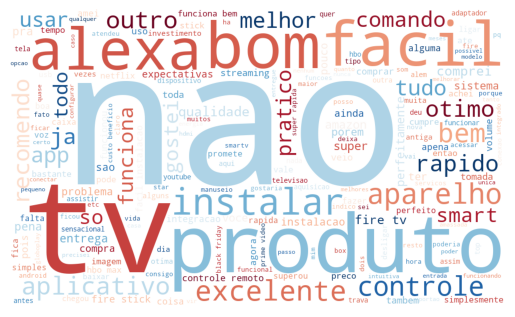

In [5]:
wcl = WordCloud(stopwords=stoplist_pt, colormap="RdBu", background_color="white", width=1000, height=600)
plt.imshow(wcl.generate(text))
plt.axis('off')

### Frequency by type

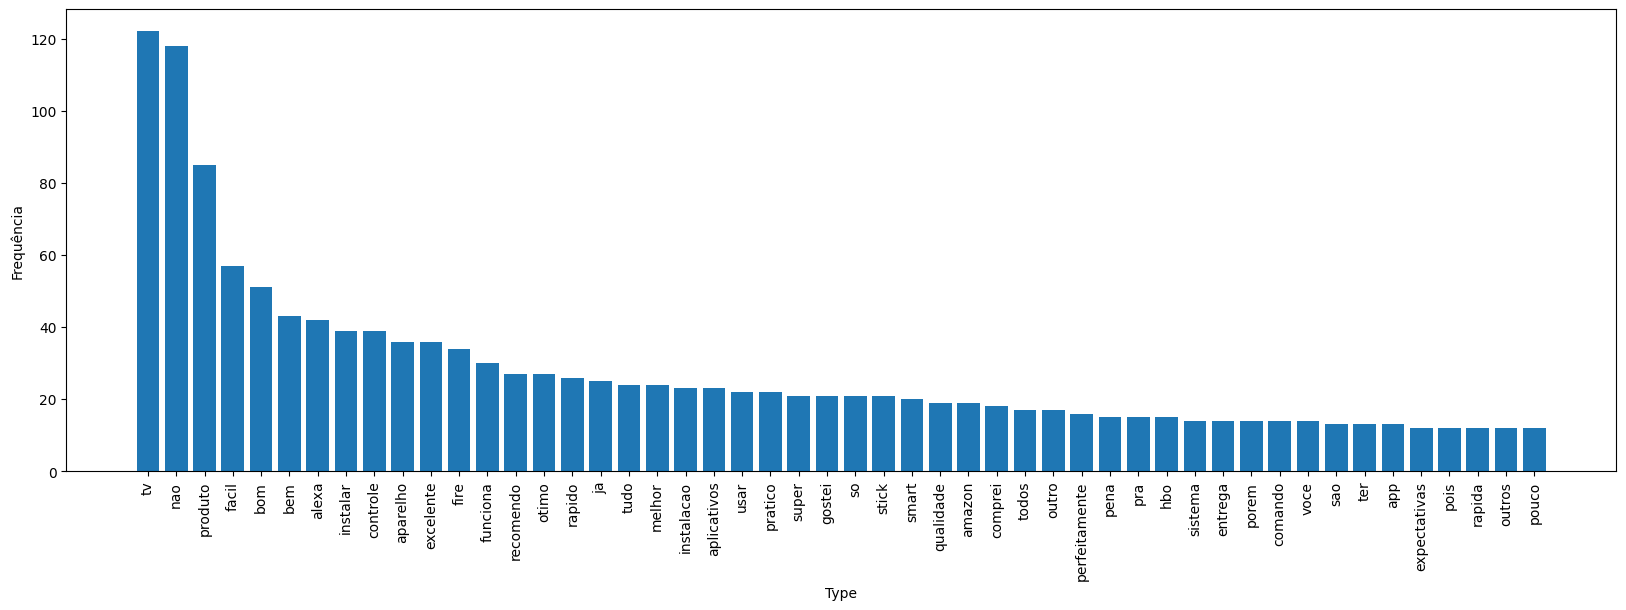

In [6]:
words = [i for i in tokens if i.lower() not in stoplist_pt]

tokens_palavras=[w for w in words if w.isalpha() and w!="s" and w!="t"]
fdist=nltk.FreqDist(tokens_palavras)
fdist_sort=fdist.most_common(50)
labels=[w for (w,f) in fdist_sort ]
freq=[f for (w,f) in fdist_sort ]
x_pos = np.arange(len(freq))
f=plt.figure()
f.set_figwidth(20)
f.set_figheight(6)
plt.bar(x_pos, freq)
plt.xticks(x_pos, labels, rotation=90)
plt.ylabel('Frequência')
plt.xlabel('Type')
plt.show()

### Frequency (f), Position (r) and Product (f*r)

In [7]:
num_types=len(set(tokens_palavras))
fdist=nltk.FreqDist(tokens_palavras)
fdist_sort=fdist.most_common(num_types)
types=[w for (w,f) in fdist_sort ]
freqs=[f for (w,f) in fdist_sort ]
ranks=list(range(1,num_types+1))
produto=np.array(freqs)*np.array(ranks)
df = pd.DataFrame(list(zip(types, freqs, ranks, produto)),
columns =['Type','Frequência(f)','Posto(r)',"f*r"])
df.head(10)

,Type,Frequência(f),Posto(r),f*r
0,tv,122,1,122
1,nao,118,2,236
2,produto,85,3,255
3,facil,57,4,228
4,bom,51,5,255
5,bem,43,6,258
6,alexa,42,7,294
7,instalar,39,8,312
8,controle,39,9,351
9,aparelho,36,10,360


### Mandelbrot

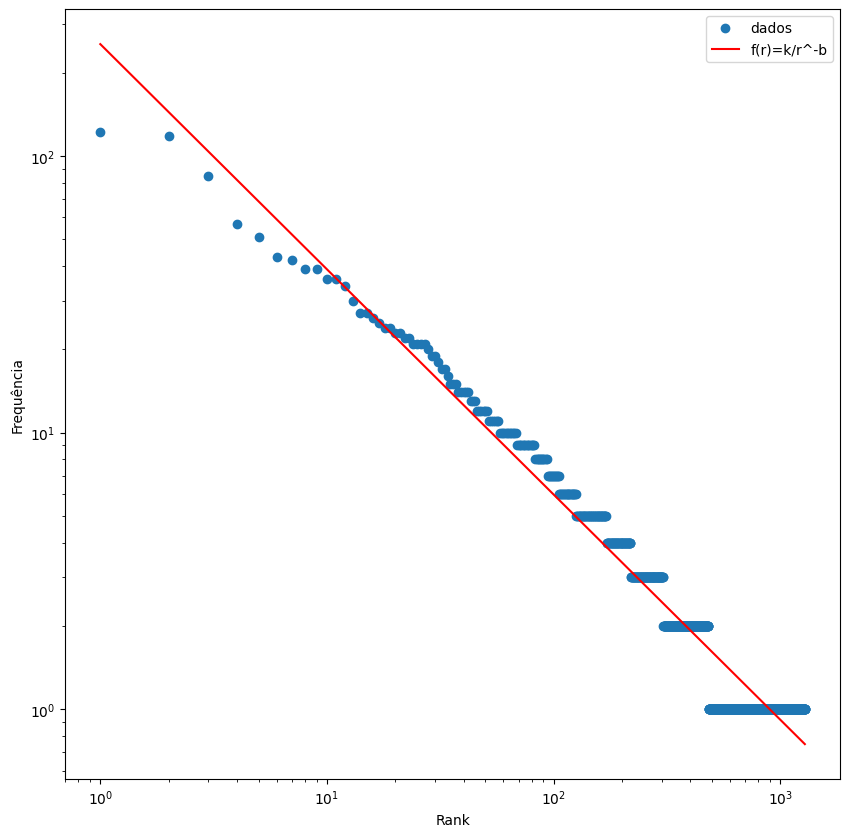

Valor estimado de b = -0.81
Valor estimado de k = 254.12


In [8]:
def func(x, a, b):
  y=a+b*x
  return y
y=np.log(np.array(freqs))
x=np.log(np.array(ranks))
w, pcov = curve_fit(func, xdata = x, ydata = y, method='lm')
a=w[0]
b=w[1]
k=math.exp(a)
f=plt.figure()
plt.plot(ranks, freqs,'o')
plt.xscale("log")
plt.yscale("log")
plt.plot(ranks,k/(np.array(ranks)**(-b)),'r')
plt.legend(('dados','f(r)=k/r^-b'),loc='upper right')
plt.ylabel('Frequência')
plt.xlabel('Rank')
f.set_figwidth(10)
f.set_figheight(10)
plt.show()
print("Valor estimado de b = {:.2f}".format(b))
print("Valor estimado de k = {:.2f}".format(k))

### Bigram and Trigram Analysis

In [9]:
def check_word(sentence):
  remove_words = [' fire', 'fire ', 'tv ', ' tv', ' stick', 'stick ', ' smart', 'smart ', 'controle ', ' controle']
  for word in remove_words:
    if word in sentence:
      return False
  return True

In [10]:
df_reviews = pd.DataFrame({'reviews': reviews})

count_vec = CountVectorizer(stop_words=stoplist_pt, ngram_range=(2,3)) # brigrams and trigrams

ngrams = count_vec.fit_transform(df_reviews['reviews'])

count_values = ngrams.toarray().sum(axis=0)

types = count_vec.vocabulary_

df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in types.items()], reverse=True)).rename(columns={0: 'frequency', 1:'ngram'})

# not_pw = not_product_words
df_ngram['not_pw'] = df_ngram['ngram'].transform(lambda x: check_word(x))
df_ngram_not_pw = df_ngram[df_ngram['not_pw']].drop(columns='not_pw')
df_ngram.drop(columns='not_pw', inplace=True)

df_ngram = df_ngram.head(50)
df_ngram_not_pw = df_ngram_not_pw.head(50)

### Without removing words related to the product

In [11]:
df_ngram.head(10)

,frequency,ngram
0,20,facil instalar
1,17,fire tv
2,15,produto bom
3,12,funciona bem
4,12,fire stick
5,11,produto excelente
6,11,facil instalacao
7,10,controle remoto
8,9,hbo max
9,9,facil usar


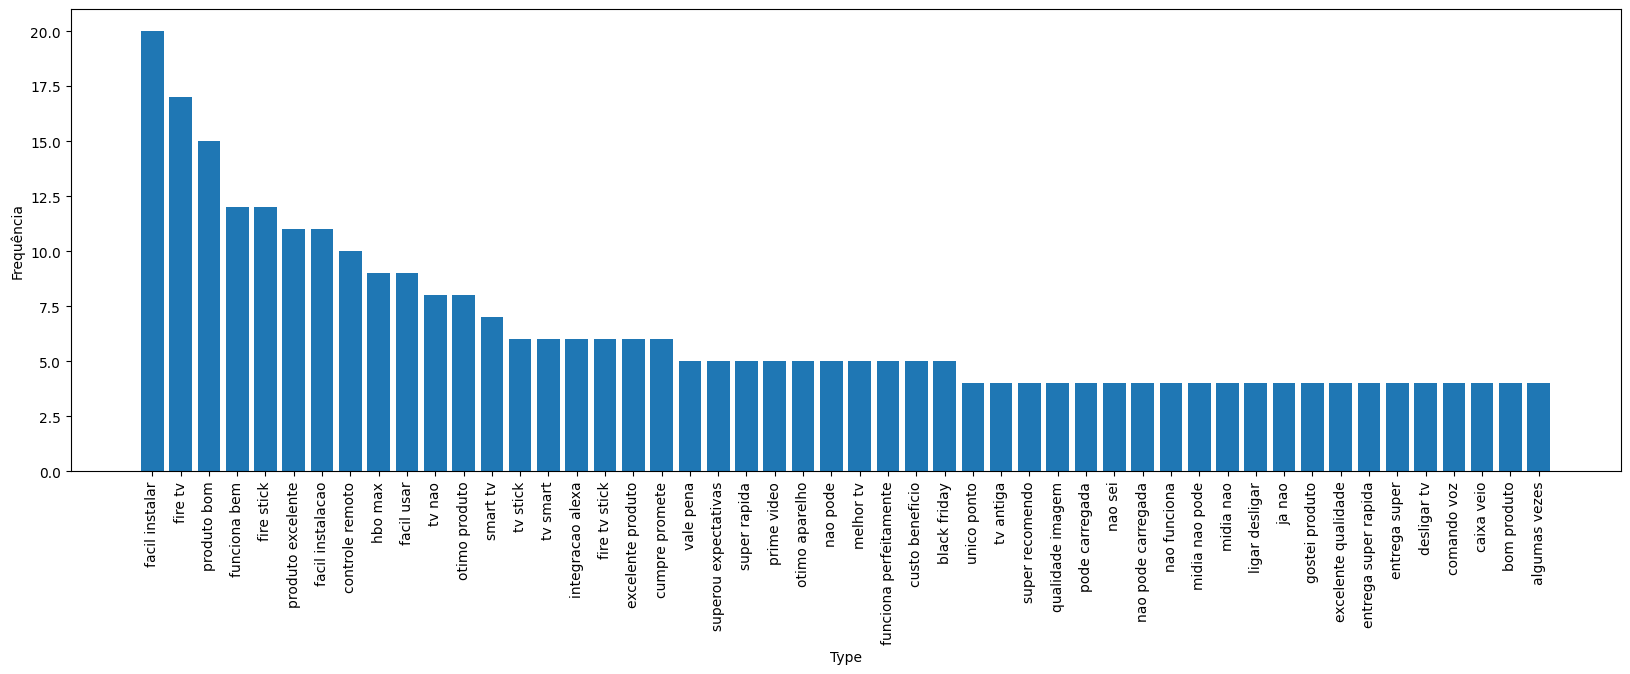

In [12]:
labels = df_ngram['ngram'].tolist()
freq = df_ngram['frequency'].tolist()
x_pos = np.arange(len(df_ngram['ngram']))
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(6)
plt.bar(x_pos, freq)
plt.xticks(x_pos, labels, rotation=90)
plt.ylabel('Frequência')
plt.xlabel('Type')
plt.show()

### Removing words related to the product

In [13]:
df_ngram_not_pw.head(10)

,frequency,ngram
0,20,facil instalar
2,15,produto bom
3,12,funciona bem
5,11,produto excelente
6,11,facil instalacao
8,9,hbo max
9,9,facil usar
11,8,otimo produto
15,6,integracao alexa
17,6,excelente produto


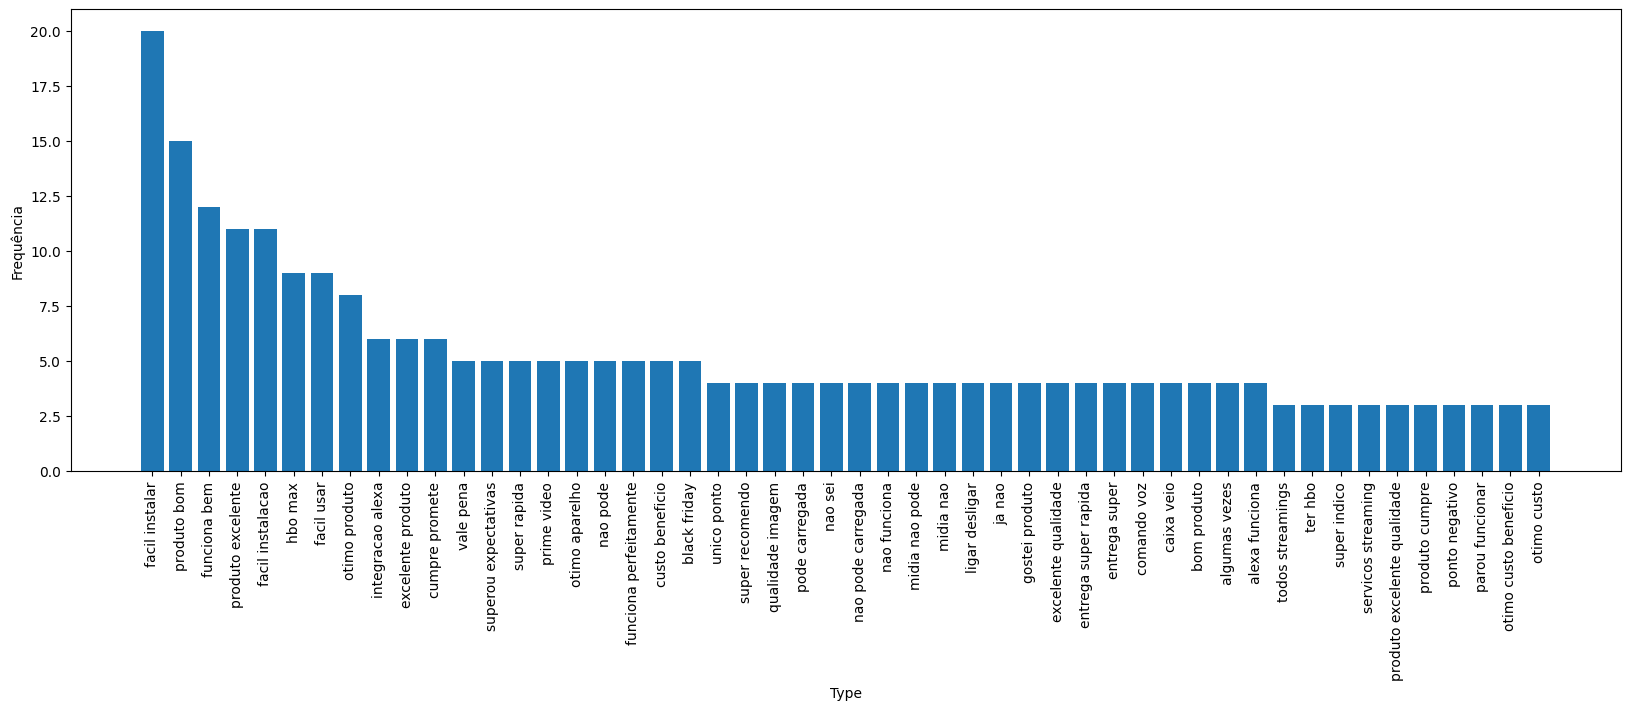

In [14]:
labels = df_ngram_not_pw['ngram'].tolist()
freq = df_ngram_not_pw['frequency'].tolist()
x_pos = np.arange(len(df_ngram_not_pw['ngram']))
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(6)
plt.bar(x_pos, freq)
plt.xticks(x_pos, labels, rotation=90)
plt.ylabel('Frequência')
plt.xlabel('Type')
plt.show()